In [204]:
%matplotlib inline

#import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import time
from scipy.spatial.distance import cdist

from collections import defaultdict

from blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

In [205]:
env = BlackjackEnv()

In [206]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [230]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1, exploration_sched='eps'):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    #Q_old = defaultdict(lambda: np.zeros(env.action_space.n))
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    delta = np.zeros((int(num_episodes/1000)+1,1))
    delta_counter = 0

    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\r Episode {}/{}, delta = {}.".format(i_episode, num_episodes, delta[delta_counter]), end="")
            sys.stdout.flush()
            delta_counter+=1
            if exploration_sched=='slow':
                    epsilon/=(delta_counter)
            elif exploration_sched== 'fast':
                    epsilon/=(delta_counter*10)
            #epsilon/=(delta_counter)
           

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
        for t in range(100):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all (state, action) pairs we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # Find the first occurance of the (state, action) pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q_new = returns_sum[sa_pair] / returns_count[sa_pair]
            delta[delta_counter]+=np.square(Q_new-Q[state][action])
            Q[state][action] = Q_new

        # The policy is improved implicitly by changing the Q dictionary

    return Q, policy, delta

In [278]:
    start = time.process_time()

    Q_eps, policy_eps, delta_eps = mc_control_epsilon_greedy(env, num_episodes=500000, 
                                                                epsilon=0.2, exploration_sched='eps')

    end = time.process_time()
    print("\r\r", end-start," s")

 77.94270800000004  s0, delta = [0.00442054].


In [264]:
    start = time.process_time()

    Q_slow, policy_slow, delta_slow = mc_control_epsilon_greedy(env, num_episodes=500000, 
                                                                epsilon=0.5, exploration_sched='slow')

    end = time.process_time()
    print("\r\r", end-start," s")

 75.20463900000004  s0, delta = [0.00029398].


In [265]:
    start = time.process_time()

    Q_fast, policy_fast, delta_fast = mc_control_epsilon_greedy(env, num_episodes=500000, 
                                                                epsilon=0.5, exploration_sched='fast')

    end = time.process_time()
    print("\r\r", end-start," s")

 74.12473500000033  s0, delta = [0.00037576].


# Plot Convergence

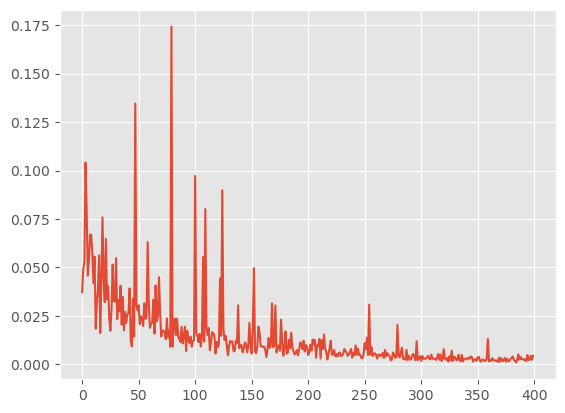

In [279]:
 x=np.arange(400)
plt.plot(x,delta_eps[100:500])
plt.show()

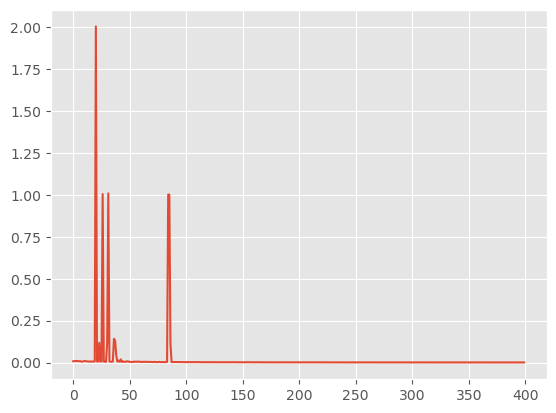

In [269]:
x=np.arange(400)
plt.plot(x,delta_fast[100:500])
plt.show()

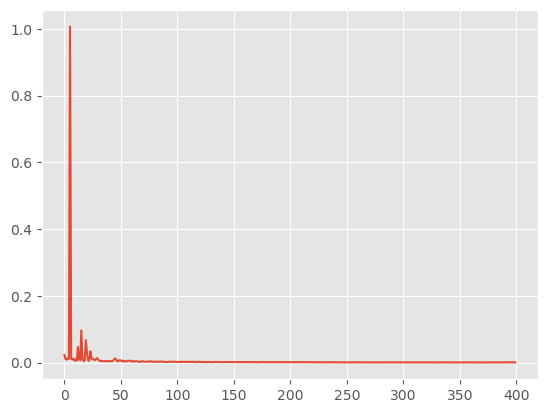

In [270]:
x=np.arange(400)
plt.plot(x,delta_slow[100:500])
plt.show()

# evaluate the policies

In [282]:
def play(env, policy, num_episodes=100, num_repetitions=1000):
    """
    Play Blackjack with the learned policy
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_mean = defaultdict(float)
    
    for i_repetition in range(1, num_repetitions):
        for i_episode in range(1, num_episodes):
            # Generate an episode.
            # An episode is an array of (state, action, reward) tuples
            episode = []
            state = env.reset()
            for t in range(100):
                probs = policy(state)
                action = np.random.choice(np.arange(len(probs)), p=probs)
                next_state, reward, done, _ = env.step(action)
                episode.append((state, action, reward))
                if done:
                    break
                state = next_state
            returns_mean[i_repetition]+=(reward)
        returns_mean[i_repetition]/=num_episodes
    mean=0
    var=0
    for val in returns_mean.values() :
        mean += val
    mean/=num_repetitions
    for val in returns_mean.values() :
        var += (val - mean)*(val-mean)
    var/=num_repetitions
    stddev=np.sqrt(var)
    print("\r Mean: {} std-deviation: {}.".format(mean, stddev), end="")
    sys.stdout.flush()
    
    return returns_mean, mean, var

In [283]:
returns, mean, var = play(env,policy_eps)

 Mean: -0.11411999999999987 std-deviation: 0.09688241442903862.

In [284]:
returns, mean, var = play(env,policy_slow)

 Mean: -0.08031999999999997 std-deviation: 0.09003913758805128.

In [285]:
returns, mean, var = play(env,policy_fast)

 Mean: -0.0937100000000001 std-deviation: 0.0948406786980145.

# Plot Policy Graphcs 

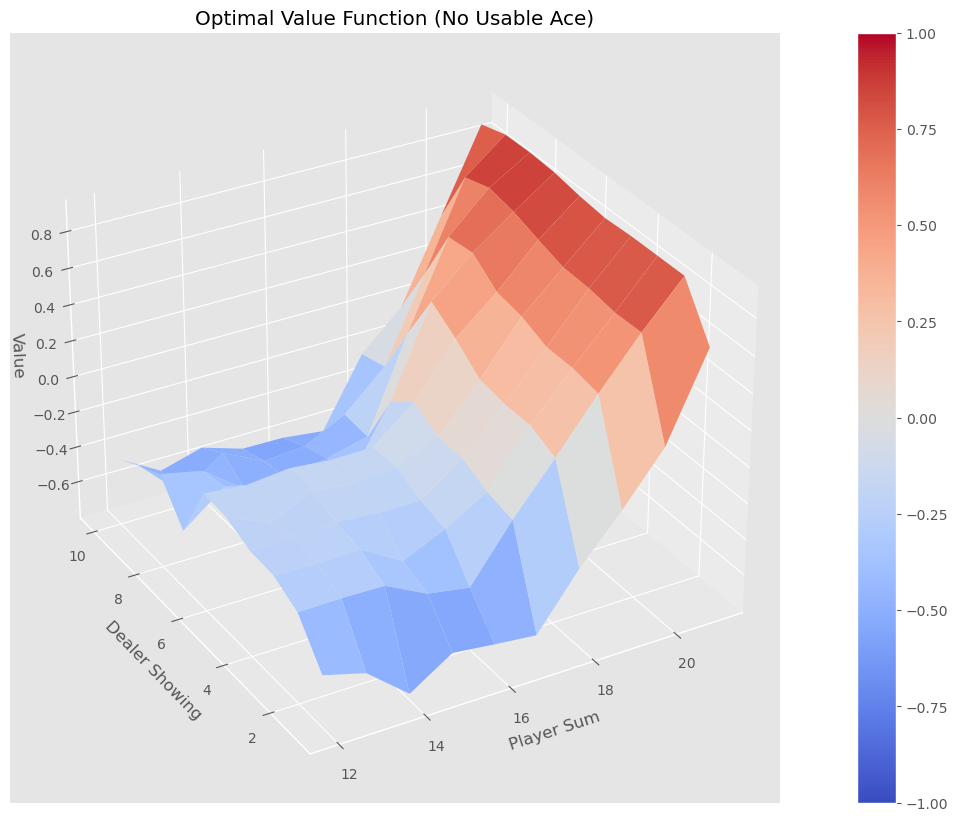

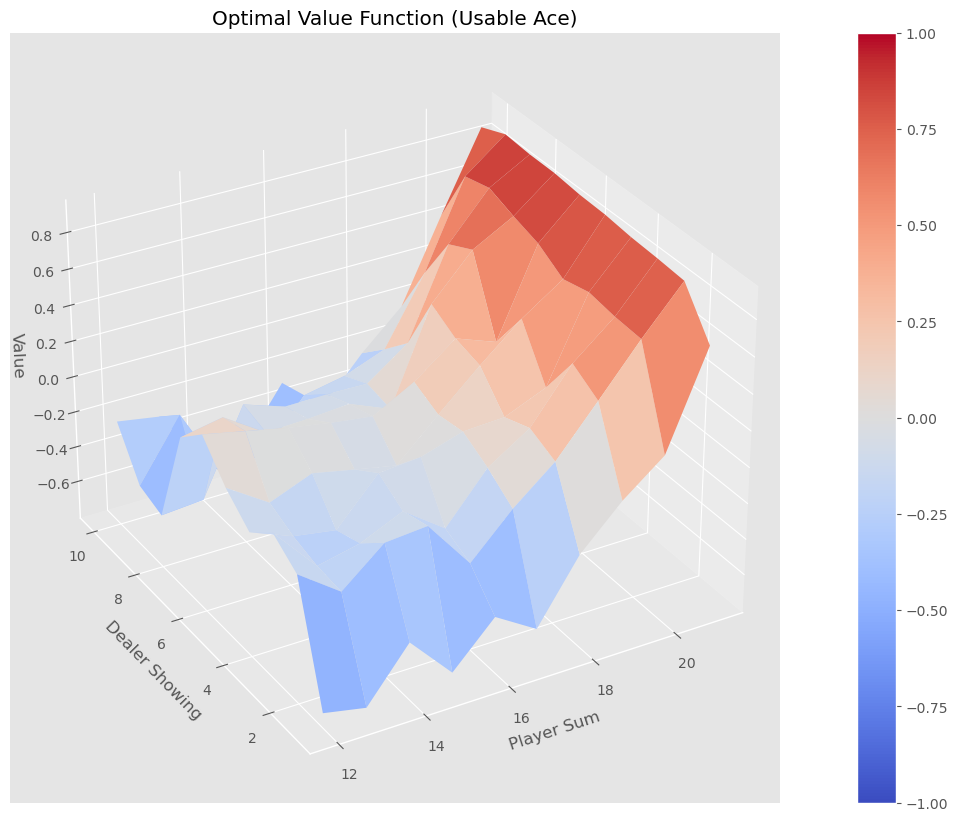

In [277]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q_slow.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

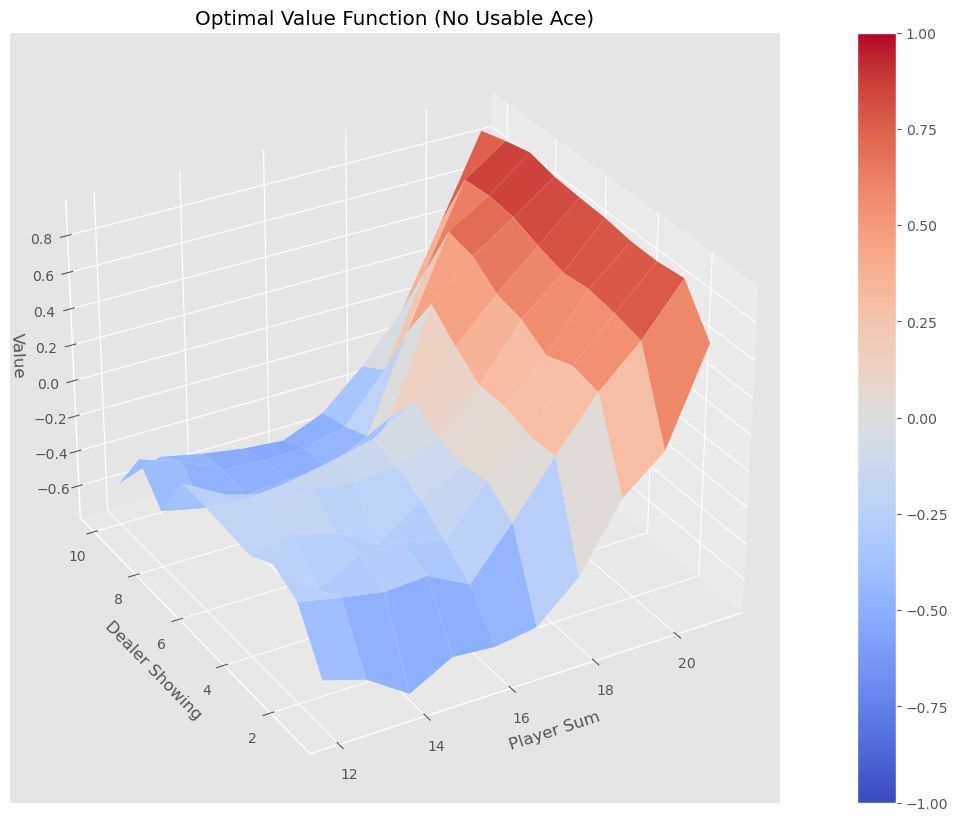

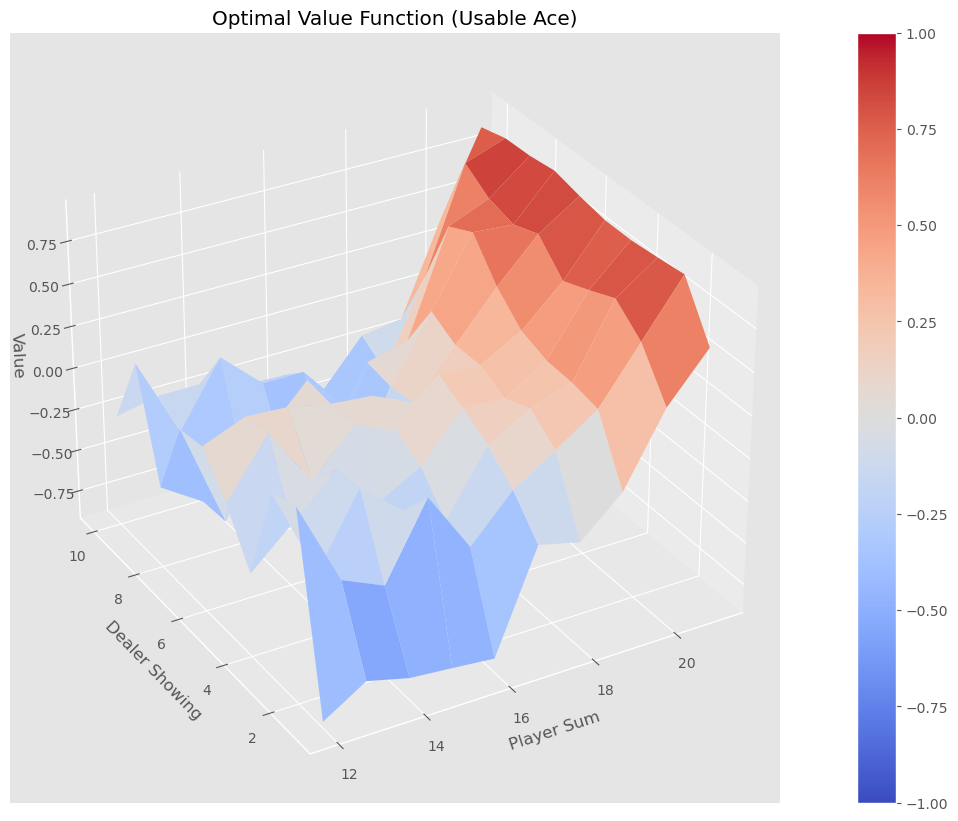

In [244]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q_slow.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")